# Cohort Project 2021: Trapped Ions

This notebook provides a solution for the "Trapped Ions" project (week 1) for the CDL cohort project of 2021. See the original Github repositiory [here](https://github.com/CDL-Quantum/CohortProject_2021).

## Instructions
This notebook has been designed to be used in a google colab environment which runs jupyter notebooks. Please follow the following instructions to set the colab kernel to Julia.
1. Copy this notebook and upload it into a google colab.
1. Execute the following cell to install Julia, IJulia and other packages. This takes a couple of minutes.
2. **Reload** this page and continue to the next section.

_Notes_:
* The setup for Julia was adapted from the [Julia template file](https://colab.research.google.com/github/ageron/julia_notebooks/blob/master/Julia_Colab_Notebook_Template.ipynb) for google colab. If you have any issues setting up, please reference that.
* If you have issues or if your runtime is disconnected, please try a factory reset on the runtime and repeat steps 2 and 3 above.

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0"
JULIA_PACKAGES="IJulia BenchmarkTools Printf Plots PastaQ LinearAlgebra ITensors"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


Defines the libraries that we want to use

In [2]:
using PastaQ
using LinearAlgebra
using ITensors
using Plots
using Printf
using Random

Define the M and R gates (adapted from the [sample script](https://github.com/CDL-Quantum/CohortProject_2021/blob/main/Week1_Trapped_Ions/run_random_circuit.jl)).

In [3]:
function PastaQ.gate(::GateName"R"; theta::Real, phi::Real)
    [
        cos(theta/2)    (-im * exp(-im * phi) * sin(theta/2))
        (-im * exp(im * phi) * sin(theta/2))     cos(theta/2)
    ]
end

function PastaQ.gate(::GateName"M"; Theta::Real)
    [
        cos(Theta)    0    0    (-im * sin(Theta))
        0    cos(Theta)    (-im * sin(Theta))    0
        0    (-im * sin(Theta))    cos(Theta)    0
        (-im * sin(Theta))    0    0    cos(Theta)
    ]
end

Define another gate enabling a bit flip (for task 2)

In [4]:
function PastaQ.gate(::GateName"E")
    [
        0    1
        1    0
    ]
end

Deinfes functions that we need.
- `construct_psi` function adapted from the [sample script](https://github.com/CDL-Quantum/CohortProject_2021/blob/main/Week1_Trapped_Ions/run_random_circuit.jl) which was previously called `run`.
  - Paramater `is_bit_flip_error_enabled`: boolean indicating if a bit flip error gate is randomly applied (used for task 2).

In [5]:
# Generates a "state" vector where 1=>"Up" and 0=>"Dn"
generate_state(vector) = [i == 1 ? "Up" : "Dn" for i=vector]

# Generates permutations i.e. [0, 0], [0, 1], [1, 0], [1, 1]
generate_permutations(n) = vec(map(collect, Iterators.product(ntuple(_ -> [0, 1], n)...)))

# Constructs bit strings as an array of MPSs given the number of qubits N
function construct_bit_strings(N)
    # Construct the basis vectors
    x_vectors = generate_permutations(N)

    # Convert the basis vectors into MPSs
    sites = siteinds("S=1/2",N)
    states = [generate_state(basis_vector) for basis_vector=x_vectors]
    x = [productMPS(sites, state) for state=states]
end

# Generates coefficients of the basis vectors x (MPS array) and psi (MPS)
generate_coefficients(x, psi) = [dot(mps, psi) for mps=x]

# Computes the probabilities for each coef by computing the square norm of each coefficient
get_bit_string_probabilities(coefficients) = [norm(coefficient)^2 for coefficient=coefficients]

# Function to generate speckle plots of probabilities
function generate_speckle_plot(probabilities, title) 
    n = length(probabilities)
    x = (range(0, stop = n, length = n + 2))[2:end - 1]
    y = (range(1, stop = 1, length = n + 2))[2:end - 1]
    min_probabilities = min(probabilities...)
    max_probabilities = max(probabilities...)
    return scatter(
      x, 
      y, 
      markersize = 15*(probabilities .- min_probabilities)./(max_probabilities - min_probabilities), 
      xlim = (0, n), 
      ylim = (0.5, 1.5), 
      legend = false, 
      xticks = [], 
      yticks = [],
      step = 20,
      title = title
  )
end

# Constructs psi as a MPS
function construct_psi(N, depth, is_bit_flip_error_enabled, dtheta)
    # Random circuit.
    gates = Vector{Tuple}[]

    # If is_bit_flip_error_enabled is true, we add a bit flip gate at a depth of idx_bit_flip_error
    idx_bit_flip_error = is_bit_flip_error_enabled ? rand(MersenneTwister(), 1: depth) : -1 # The use of MersenneTwister() ensures idx_bit_flip_error is random despite any seed

    for i in 1:depth
        one_qubit_layer = Tuple[]
        two_qubit_layer = Tuple[]

        for j in 1:N
            gate = ("R", j, (theta=2pi*rand(), phi=2pi*rand()))
            push!(one_qubit_layer, gate)
        end

        # Alternate start qubit for pairs.
        idx_first = i % 2 + 1

        for j in idx_first:2:(N-1)
            gate = ("M", (j, j+1), (Theta=2pi*rand() + dtheta,))
            push!(two_qubit_layer, gate)
        end

        push!(gates, one_qubit_layer)
        push!(gates, two_qubit_layer)

        if (idx_bit_flip_error == i)
          # Adds the bit flip gate
          err_qubit_layer = Tuple[]
          for j in 1:N 
              gate = ("E", j)
              push!(err_qubit_layer, gate)
          end
          push!(gates, err_qubit_layer)
        end
    end

    psi = runcircuit(N, gates)
end

construct_psi (generic function with 1 method)

## Solution for task 1

We test permutations of number of qubits 4, 8 and 12 and depths 1, 5 and 10. Bit string probabilities are plotted below.

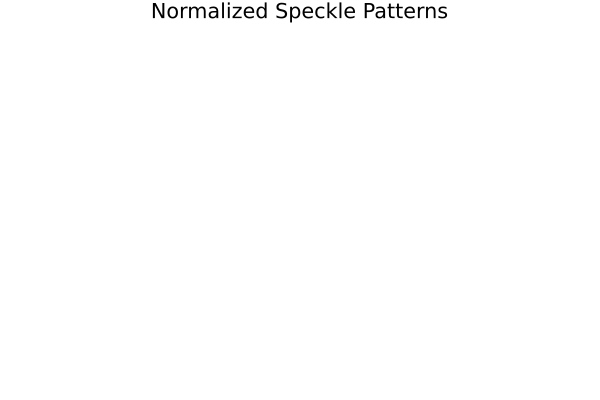

In [6]:
# This block contains the code to solve task 1


Random.seed!(1234) # Sets the seed
Ns = [4, 8, 12] # Number of qubits to test
depths = [1, 256, 512] # Depths to test
plots = []

for N in Ns
  for depth in depths
    # Constructs the bit strings
    x = construct_bit_strings(N)

    # Generates psi
    psi = construct_psi(N, depth, false, 0)

    # Gets each coefficient 
    coefficients = generate_coefficients(x, psi)

    # Computes the probability
    probabilities = get_bit_string_probabilities(coefficients)

    # Generate the "speckle pattern" plots
    title = @sprintf("%d qubits circuit depth %d", N, depth)
    # display(plot(probabilities, markersize = probabilities, title = title))
    plot_instance = generate_speckle_plot(probabilities, title)
    push!(plots, plot_instance)
  end
end
display(plot(title = "Normalized Speckle Patterns", framestyle=nothing, showaxis=false, xticks=false, yticks=false, marginBottom="0mm")) # Hacky way to add a super title
plot(plots...)
plot!(size=(1000,1000))



## Solution for task 2
We observe very different probability distributions when enabling random bit flips. Here we show 9 runs of the same random circuit but with random bit flips enabled.

Notes:
- Sometimes, you might see the same distribution if the bit flip happens to be at the same location in the circuit

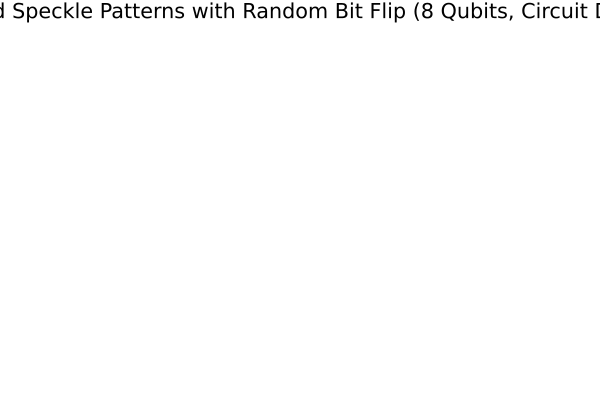

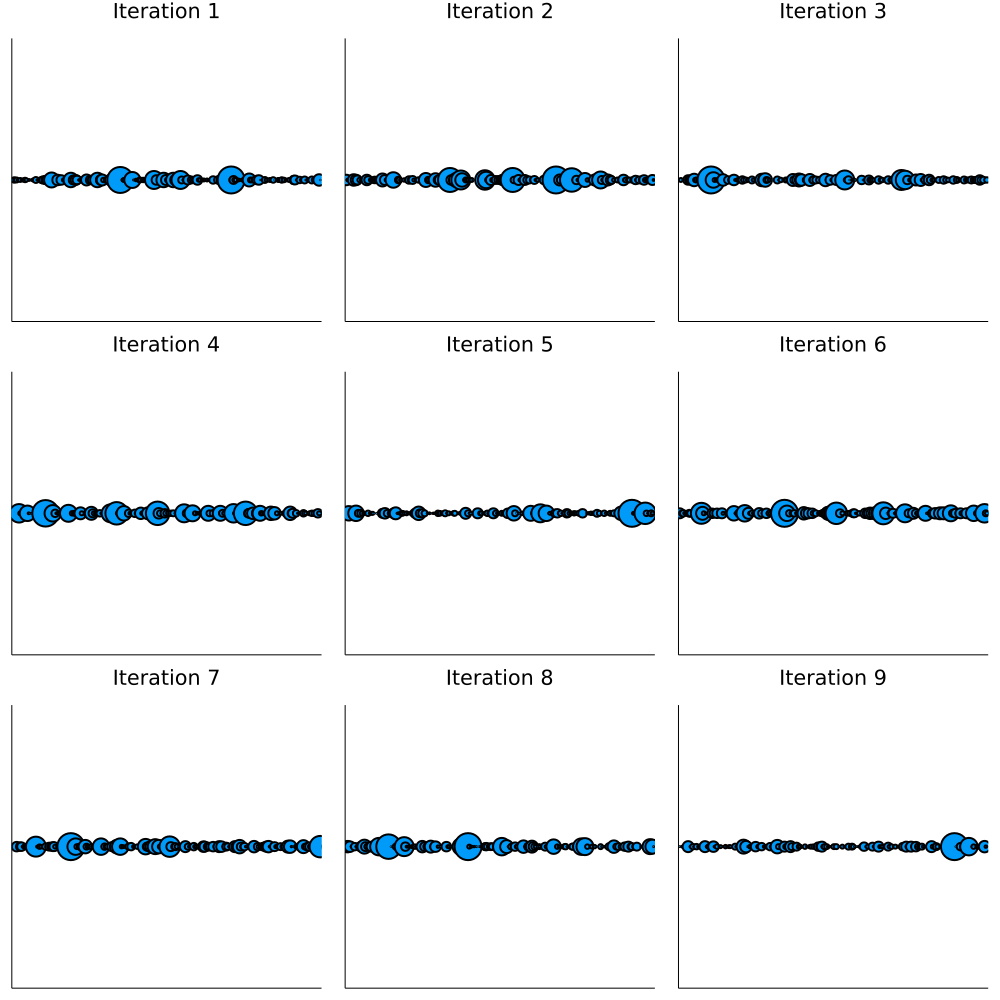

Plots.AnimatedGif("/Users/eli/Desktop/CohortProject_2021/Week1_Trapped_Ions/tutorial_anim_fps30.gif")
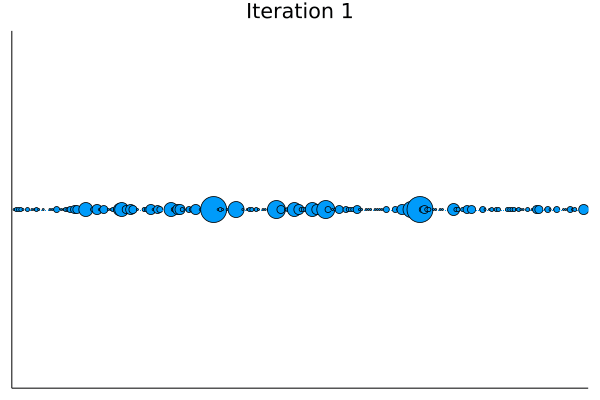

┌ Info: Saved animation to 
│   fn = /Users/eli/Desktop/CohortProject_2021/Week1_Trapped_Ions/tutorial_anim_fps30.gif
└ @ Plots /Users/eli/.julia/packages/Plots/isZEW/src/animation.jl:104


Plots.AnimatedGif("/Users/eli/Desktop/CohortProject_2021/Week1_Trapped_Ions/tutorial_heatmap_anim.gif")
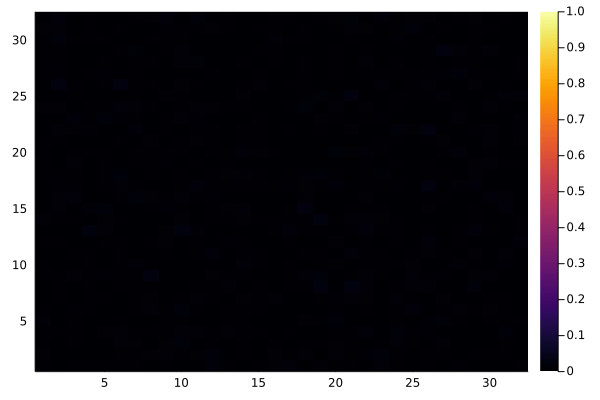

┌ Info: Saved animation to 
│   fn = /Users/eli/Desktop/CohortProject_2021/Week1_Trapped_Ions/tutorial_heatmap_anim.gif
└ @ Plots /Users/eli/.julia/packages/Plots/isZEW/src/animation.jl:104


In [7]:
# This block contains code to solve task 2

###heatmap is working- need to further normalize values so that perturbations can be seen easier

Random.seed!(1234) # Sets the seed
n_iterations = 9 # Number of times to run the circuit
N = 8 # Number of qubits
depth = 256 # Depth of the circuit
plots = []
all_probabilities = []

# Constructs the bit strings
x = construct_bit_strings(N)

for iteration in 1:n_iterations
    # Generates psi with bit error enabled
    psi = construct_psi(N, depth, true, 0)

    # Gets each coefficient 
    coefficients = generate_coefficients(x, psi)

    # Computes the probability
    probabilities = get_bit_string_probabilities(coefficients)
    push!(all_probabilities, probabilities)

    # Generate the "speckle pattern"
    title = @sprintf("Iteration %d", iteration)
    # display(plot(probabilities, markersize = probabilities, title = title))
    plot_instance = generate_speckle_plot(probabilities, title)
    push!(plots, plot_instance)
end
title = @sprintf("Normalized Speckle Patterns with Random Bit Flip (%d Qubits, Circuit Depth %d)", N, depth)
display(plot(title = title, framestyle=nothing, showaxis=false, xticks=false, yticks=false, marginBottom="0mm")) # Hacky way to add a super title
plot(plots...)
display(plot!(size=(1000,1000)))

# Bonus: Animation of speckle plots
df = 1
anim = @animate for i = 1:df:length(plots), j = 1:3:length(plots)
     plot(plots[i])
end
display(gif(anim, "tutorial_anim_fps30.gif", fps = 2))

# Extra: show a sweet heatmap
anim = @animate for i = 1:length(all_probabilities)
    mat = rand(all_probabilities[i], 32, 32)
    heatmap(mat, clim=(0,1))
end
 
display(gif(anim, "tutorial_heatmap_anim.gif", fps = 3))

## Solution for task 3
We see the approximate solution is very close to the exact CDF.

In [8]:
###should make the range from 10^-2 to 1 (it's less accurate near 10^-3)

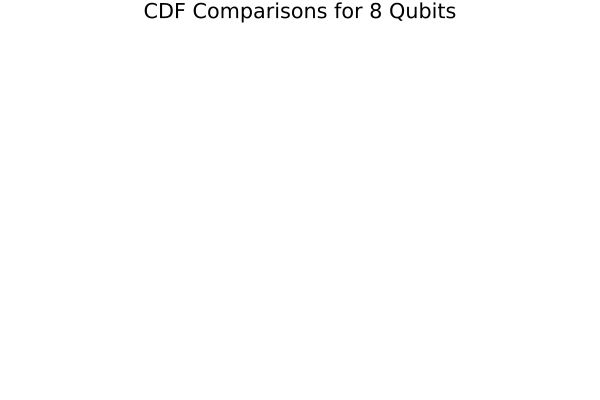

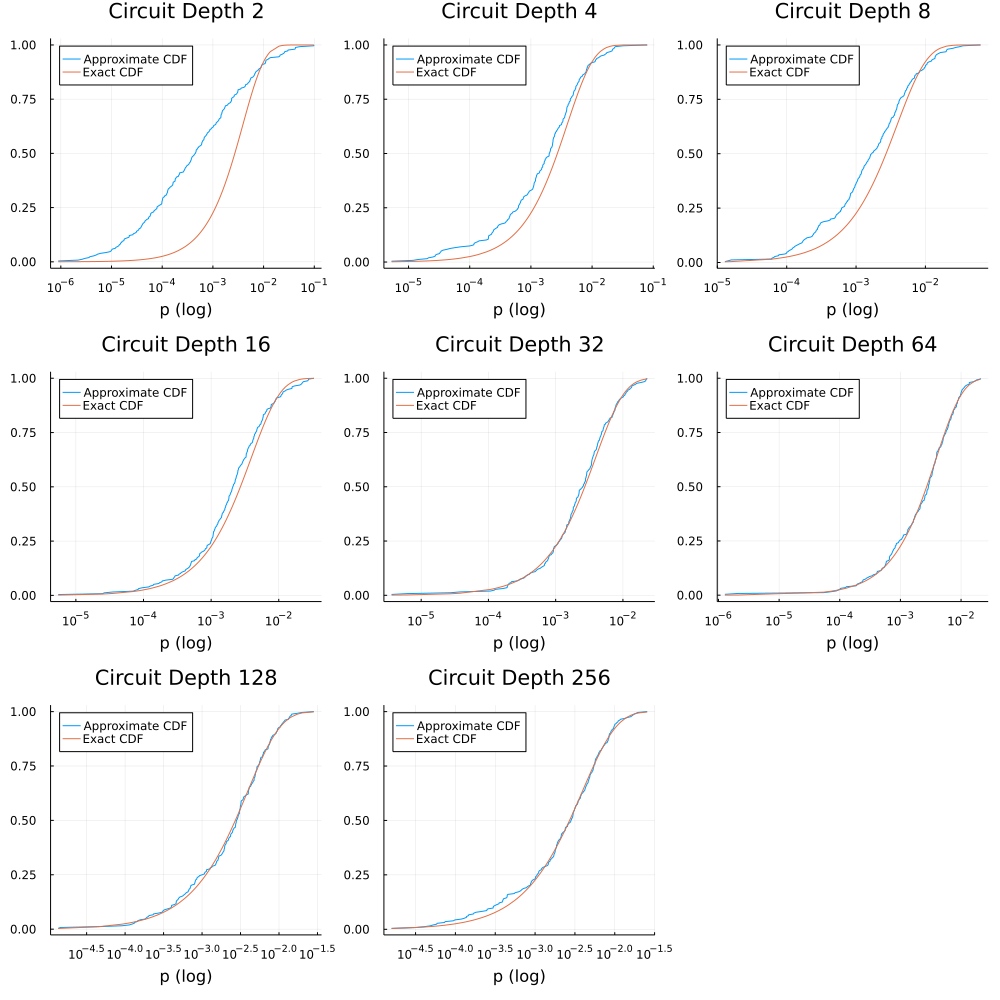

In [9]:
Random.seed!(1234) # Sets the seed
N = 8 # Number of qubits
depths = [2^n for n in 1:8] # Depth of circuit
plots = []

f(x) = 1 - exp(-x*(2^N)) # Exact CDF

for depth in depths
    # Generates psi with bit error not enabled
    psi = construct_psi(N, depth, false, 0)

    # Gets each coefficient 
    coefficients = generate_coefficients(x, psi)

    # Computes the probability
    probabilities = get_bit_string_probabilities(coefficients)

    # Generate the plot
    title = @sprintf("Circuit Depth %d", depth)
    plot_instance = plot(sort(probabilities), [[1:length(probabilities)]./length(probabilities), f], xaxis=:log, label = ["Approximate CDF" "Exact CDF"], xlabel = "p (log)", title = title, legend=:topleft)
    push!(plots, plot_instance)
end
title = @sprintf("CDF Comparisons for %d Qubits", N)
display(plot(title = title, framestyle=nothing, showaxis=false, xticks=false, yticks=false, marginBottom="0mm")) # Hacky way to add a super title
plot(plots...)
plot!(size=(1000,1000))

Task 4

In [10]:
perturbations = [-0.1, -0.01, 0.1, 0.01, 0.5]

all_probabilities_pert = []

for dtheta in perturbations

    psi = construct_psi(N, depth, true, dtheta)

    # Gets each coefficient 
    coefficients = generate_coefficients(x, psi)

    # Computes the probability
    probabilities = get_bit_string_probabilities(coefficients)
    push!(all_probabilities_pert, probabilities)

end

In [11]:
fid = []

for i in 1:1:length(all_probabilities_pert)

    fidelity = (2^N)*sum(all_probabilities_pert[i][50:200])/length(all_probabilities_pert[i][50:200]) - 1
    push!(fid, fidelity)
    
end

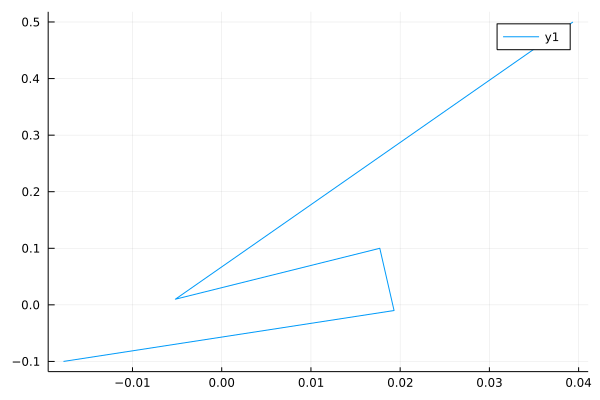

In [13]:
plot(fid, perturbations)